In [42]:
"""
import pandas as pd

# Cargar el archivo CSV
file_path = 'df_listing_clean_price.csv'
df_listing_clean_price = pd.read_csv(file_path)

# Crear la tabla 'civitatis_airbnb_listing' sin índice
listing_columns = [
    'listing_id', 'host_id', 'longitude', 'latitude', 
    'room_type', 'accommodates', 'instant_bookable', 'base_price'
]
civitatis_airbnb_listing = df_listing_clean_price[listing_columns].copy(deep=True)

# Crear la tabla 'civitatis_airbnb_reviews' sin índice
reviews_columns = [
    'listing_id', 'number_of_reviews', 'number_of_reviews_ltm', 
    'number_of_reviews_l30d', 'review_scores_rating'
]
civitatis_airbnb_reviews = df_listing_clean_price[reviews_columns].copy(deep=True)

# Renombrar columnas en civitatis_airbnb_reviews
civitatis_airbnb_reviews.rename(columns={
    'number_of_reviews_ltm': 'reviews_lastyear',
    'number_of_reviews_l30d': 'reviews_last30days'
}, inplace=True)

# Añadir una columna 'reviews_id' para identificación única en 'civitatis_airbnb_reviews'
civitatis_airbnb_reviews['reviews_id'] = range(len(civitatis_airbnb_reviews))

# Mover la columna 'reviews_id' a la primera posición
cols = ['reviews_id'] + [col for col in civitatis_airbnb_reviews.columns if col != 'reviews_id']
civitatis_airbnb_reviews = civitatis_airbnb_reviews[cols]

# Crear la tabla 'civitatis_airbnb_host' y eliminar duplicados
host_columns = [
    'host_id', 'host_name', 'host_since', 'host_location', 
    'host_response_time', 'host_is_superhost', 'host_listings_count'
]
civitatis_airbnb_host = df_listing_clean_price[host_columns].drop_duplicates(subset='host_id').copy(deep=True)

# Asegurarse de que no hay columnas índice
civitatis_airbnb_listing.reset_index(drop=True, inplace=True)
civitatis_airbnb_reviews.reset_index(drop=True, inplace=True)
civitatis_airbnb_host.reset_index(drop=True, inplace=True)

# Exportar los DataFrames a CSV
civitatis_airbnb_listing.to_csv('civitatis_airbnb_listing.csv', index=False)
civitatis_airbnb_reviews.to_csv('civitatis_airbnb_reviews.csv', index=False)
civitatis_airbnb_host.to_csv('civitatis_airbnb_host.csv', index=False)
"""

"\nimport pandas as pd\n\n# Cargar el archivo CSV\nfile_path = 'df_listing_clean_price.csv'\ndf_listing_clean_price = pd.read_csv(file_path)\n\n# Crear la tabla 'civitatis_airbnb_listing' sin índice\nlisting_columns = [\n    'listing_id', 'host_id', 'longitude', 'latitude', \n    'room_type', 'accommodates', 'instant_bookable', 'base_price'\n]\ncivitatis_airbnb_listing = df_listing_clean_price[listing_columns].copy(deep=True)\n\n# Crear la tabla 'civitatis_airbnb_reviews' sin índice\nreviews_columns = [\n    'listing_id', 'number_of_reviews', 'number_of_reviews_ltm', \n    'number_of_reviews_l30d', 'review_scores_rating'\n]\ncivitatis_airbnb_reviews = df_listing_clean_price[reviews_columns].copy(deep=True)\n\n# Renombrar columnas en civitatis_airbnb_reviews\ncivitatis_airbnb_reviews.rename(columns={\n    'number_of_reviews_ltm': 'reviews_lastyear',\n    'number_of_reviews_l30d': 'reviews_last30days'\n}, inplace=True)\n\n# Añadir una columna 'reviews_id' para identificación única en 'ci

In [43]:
!pip install sqlalchemy pymysql matplotlib folium pandas

In [44]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import folium
from IPython.display import IFrame

# Configuración de la base de datos y la conexión
bd = "civitatis_airbnb"  # Cambia esto al nombre correcto de tu base de datos
password = 'password'  # Introduce la contraseña directamente aquí
connection_string = 'mysql+pymysql://root:' + password + '@localhost/' + bd
engine = create_engine(connection_string)

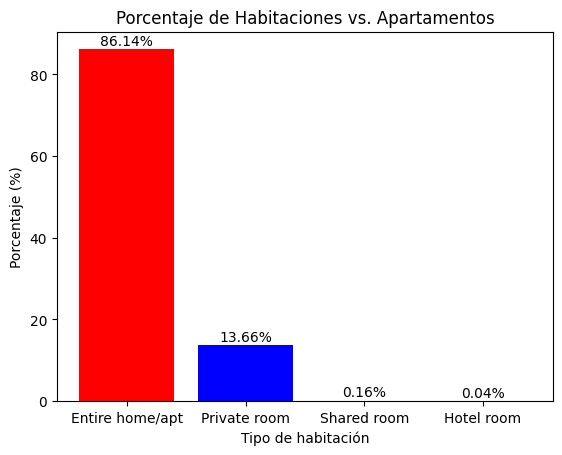

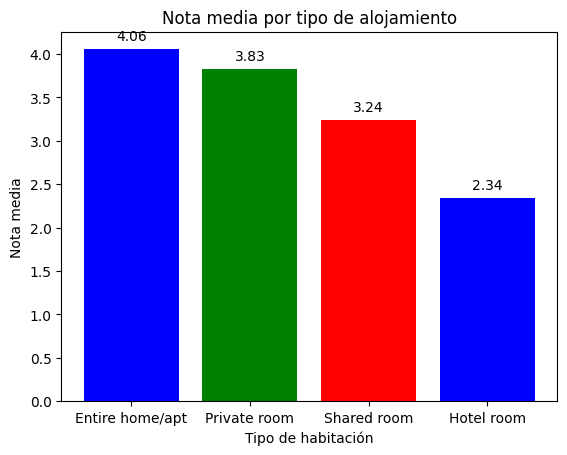

In [51]:
# --- Hipótesis 1 ---

# Consulta 1: Porcentaje de habitaciones vs. apartamentos
consulta_porcentaje_habitaciones = """
SELECT 
    room_type, 
    COUNT(listing_id) AS total_listings,
    COUNT(listing_id) * 100.0 / (SELECT COUNT(listing_id) FROM civitatis_airbnb.listing) AS percentage
FROM civitatis_airbnb.listing
GROUP BY room_type;
"""
df_room_type_percentage = pd.read_sql(consulta_porcentaje_habitaciones, con=engine)

# Crear gráfica de barras
plt.bar(df_room_type_percentage['room_type'], df_room_type_percentage['percentage'], color=['red', 'blue', 'green'])
plt.xlabel('Tipo de habitación')
plt.ylabel('Porcentaje (%)')
plt.title('Porcentaje de Habitaciones vs. Apartamentos')
for idx, value in enumerate(df_room_type_percentage['percentage']):
    plt.text(idx, value + 1, f'{value:.2f}%', ha='center')
plt.show()

# Consulta 2: Mapa de localización según tipo de habitación
consulta_mapa_habitaciones = """
SELECT listing_id, room_type, longitude, latitude
FROM civitatis_airbnb.listing;
"""
df_map_room_type = pd.read_sql(consulta_mapa_habitaciones, con=engine)

# Crear el mapa
map_room_type = folium.Map(location=[36.7213, -4.4216], zoom_start=12)
color_dict = {'Entire home/apt': 'blue', 'Private room': 'green', 'Shared room': 'red'}

# Añadir puntos al mapa
for idx, row in df_map_room_type.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color_dict.get(row['room_type'], 'gray'),
        fill=True,
        fill_color=color_dict.get(row['room_type'], 'gray'),
        fill_opacity=0.7
    ).add_to(map_room_type) 

# Añadir leyenda
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 180px; height: 120px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 ">&nbsp; <b>Room Type</b> <br>
                 &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; Entire home/apt <br>
                 &nbsp; <i class="fa fa-circle" style="color:green"></i>&nbsp; Private room <br>
                 &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; Shared room
     </div>
'''
map_room_type.get_root().html.add_child(folium.Element(legend_html))
map_room_type.save('room_type_map.html')

# Mostrar el mapa en el notebook
IFrame('room_type_map.html', width=800, height=600)

# Consulta 3: Nota media por tipo de habitación
consulta_nota_media = """
SELECT room_type, AVG(review_scores_rating) AS reviews_avg
FROM civitatis_airbnb.listing
JOIN civitatis_airbnb.reviews ON listing.listing_id = reviews.listing_id
GROUP BY room_type;
"""
df_reviews_avg = pd.read_sql(consulta_nota_media, con=engine)

# Crear gráfica de barras para nota media
plt.bar(df_reviews_avg['room_type'], df_reviews_avg['reviews_avg'], color=['blue', 'green', 'red'])
plt.xlabel('Tipo de habitación')
plt.ylabel('Nota media')
plt.title('Nota media por tipo de alojamiento')
for idx, value in enumerate(df_reviews_avg['reviews_avg']):
    plt.text(idx, value + 0.1, f'{value:.2f}', ha='center')
plt.show()



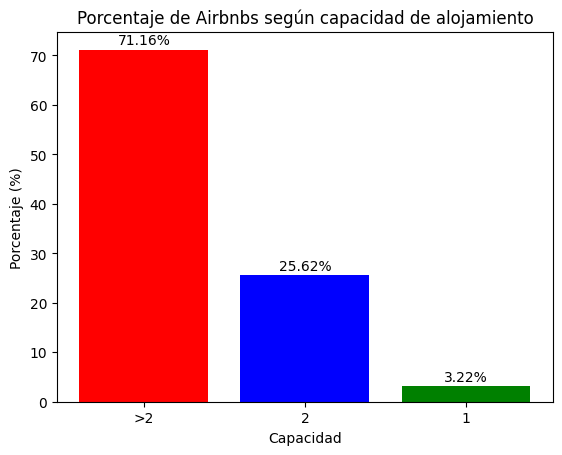

In [45]:
# --- Hipótesis 2 ---

# Consulta SQL para clasificar los alojamientos por capacidad y calcular porcentajes
consulta_clasificacion = """
SELECT 
    CASE 
        WHEN accommodates = 1 THEN '1'
        WHEN accommodates = 2 THEN '2'
        ELSE '>2'
    END AS capacity_classification,
    COUNT(*) AS total_listings,
    (COUNT(*) * 100.0 / (SELECT COUNT(*) FROM listing)) AS percentage
FROM listing
GROUP BY capacity_classification
"""

# Ejecutar la consulta y guardar el resultado en un DataFrame descriptivo
df_airbnb_capacity_percentage = pd.read_sql(consulta_clasificacion, con=engine)

# Crear la gráfica de barras
plt.bar(df_airbnb_capacity_percentage['capacity_classification'], df_airbnb_capacity_percentage['percentage'], color=['red', 'blue', 'green'])
plt.xlabel('Capacidad')
plt.ylabel('Porcentaje (%)')
plt.title('Porcentaje de Airbnbs según capacidad de alojamiento')

# Añadir los valores encima de las barras
for idx, value in enumerate(df_airbnb_capacity_percentage['percentage']):
    plt.text(idx, value + 1, f'{value:.2f}%', ha='center')

plt.show()

# Consulta SQL para obtener la información para el mapa
consulta_mapa = """
SELECT 
    latitude,
    longitude,
    CASE 
        WHEN accommodates = 1 THEN '1'
        WHEN accommodates = 2 THEN '2'
        ELSE '>2'
    END AS capacity_classification
FROM listing
"""

# Ejecutar la consulta y guardar el resultado en un DataFrame descriptivo
df_airbnb_map_data = pd.read_sql(consulta_mapa, con=engine)


# Crear un mapa centrado en una ubicación (por ejemplo, Málaga)
map_airbnb = folium.Map(location=[36.7213, -4.4216], zoom_start=12)

# Colores para las diferentes capacidades
color_dict = {'1': 'red', '2': 'blue', '>2': 'green'}

# Añadir puntos al mapa
for idx, row in df_airbnb_map_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color_dict[row['capacity_classification']],
        fill=True,
        fill_color=color_dict[row['capacity_classification']],
        fill_opacity=0.7
    ).add_to(map_airbnb)

# Añadir una leyenda al mapa
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 250px; height: 110px; 
                 background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
                 ">&nbsp; <b>Capacidad de los alojamientos</b> <br>
                 &nbsp; <i class="fa fa-circle" style="color:red"></i>&nbsp; 1 persona <br>
                 &nbsp; <i class="fa fa-circle" style="color:blue"></i>&nbsp; 2 personas <br>
                 &nbsp; <i class="fa fa-circle" style="color:green"></i>&nbsp; >2 personas
     </div>
'''
map_airbnb.get_root().html.add_child(folium.Element(legend_html))

# Guardar el mapa en un archivo HTML
map_airbnb.save('airbnb_map.html')




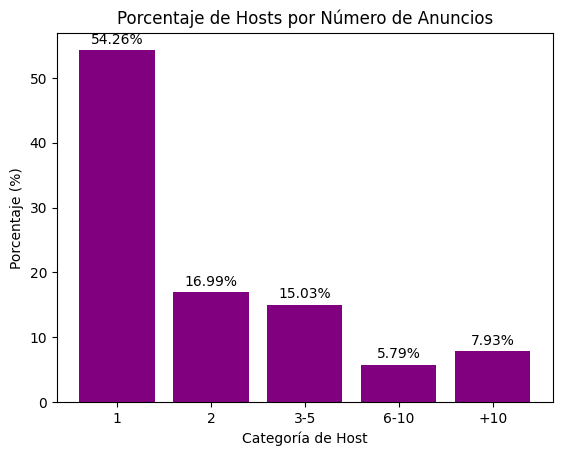

,host_name,total_listings
0,I Loft Malaga,194
1,Maria,157
2,Javier,157
3,Remy,127
4,Antonio,110
5,Living4Malaga,106
6,Caleta Homes,105
7,David,98
8,Holidu,95
9,Andrea,85


In [54]:
# --- Hipótesis 3 ---

# Consulta 4: Tabla de hosts por número de anuncios
consulta_hosts_anuncios = """
SELECT 
    CASE
        WHEN host_listings_count = 1 THEN '1'
        WHEN host_listings_count = 2 THEN '2'
        WHEN host_listings_count BETWEEN 3 AND 5 THEN '3-5'
        WHEN host_listings_count BETWEEN 6 AND 10 THEN '6-10'
        WHEN host_listings_count > 10 THEN '+10'
        ELSE 'Sin categoría'
    END AS host_category,
    COUNT(host_id) AS total_hosts,
    (COUNT(host_id) * 100 / (SELECT COUNT(*) FROM civitatis_airbnb.host)) AS percentage
FROM civitatis_airbnb.host
GROUP BY host_category;
"""
df_hosts_category = pd.read_sql(consulta_hosts_anuncios, con=engine)

# Ordenar el DataFrame para que las categorías aparezcan en orden lógico
category_order = ['1', '2', '3-5', '6-10', '+10', 'Sin categoría']
df_hosts_category['host_category'] = pd.Categorical(df_hosts_category['host_category'], categories=category_order, ordered=True)
df_hosts_category = df_hosts_category.sort_values('host_category')

# Crear gráfica de barras para hosts por número de anuncios
plt.bar(df_hosts_category['host_category'], df_hosts_category['percentage'], color='purple')
plt.xlabel('Categoría de Host')
plt.ylabel('Porcentaje (%)')
plt.title('Porcentaje de Hosts por Número de Anuncios')
for idx, value in enumerate(df_hosts_category['percentage']):
    plt.text(idx, value + 1, f'{value:.2f}%', ha='center')
plt.show()

# Consulta 5: Top 10 hosts según número de inmuebles
consulta_top_hosts = """
SELECT host_name, COUNT(listing.listing_id) AS total_listings
FROM civitatis_airbnb.listing
JOIN civitatis_airbnb.host ON listing.host_id = host.host_id
GROUP BY host_name
ORDER BY total_listings DESC
LIMIT 10;
"""
df_top_hosts = pd.read_sql(consulta_top_hosts, con=engine)

# Mostrar la tabla de los Top 10 hosts
display(df_top_hosts)